In [ ]:
!pip -p install http://download.pytorch.org/whl/cu80/torch-0.1.12.post2-cp27-none-linux_x86_64.whl
!git clone https://github.com/meliketoy/wide-resnet.pytorch



Usage:   
  pip3 <command> [options]

no such option: -p
Cloning into 'wide-resnet.pytorch'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 124 (delta 29), reused 29 (delta 29), pack-reused 89
Receiving objects: 100% (124/124), 670.63 KiB | 5.28 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
import torchvision
import math

import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random as rand
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import pandas as pd

import pickle
from PIL import Image

In [ ]:
train_data=CIFAR10(root="data",train=True,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 66698378.76it/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
test_data = CIFAR10(root="data",train=False,download=True,transform=ToTensor())

Files already downloaded and verified


In [ ]:
import os
print(os.listdir("./data/cifar-10-batches-py"))

['readme.html', 'batches.meta', 'data_batch_2', 'data_batch_5', 'test_batch', 'data_batch_3', 'data_batch_4', 'data_batch_1']


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
def load_cifar10_data(filename):
    with open('./data/cifar-10-batches-py/'+ filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data']
    labels = batch['labels']
    return features, labels

In [ ]:
batch_1, labels_1 = load_cifar10_data('data_batch_1')
batch_2, labels_2 = load_cifar10_data('data_batch_2')
batch_3, labels_3 = load_cifar10_data('data_batch_3')
batch_4, labels_4 = load_cifar10_data('data_batch_4')
batch_5, labels_5 = load_cifar10_data('data_batch_5')

test, label_test = load_cifar10_data('test_batch')

In [ ]:
X_train = np.concatenate([batch_1,batch_2,batch_3,batch_4,batch_5], 0)
X_test=np.concatenate([test])
Y_train = np.concatenate([labels_1,labels_2,labels_3,labels_4,labels_5], 0)
Y_test=np.concatenate([label_test])

In [ ]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 3072)
Y_train shape: (50000,)
X_test shape: (10000, 3072)
Y_test shape: (10000,)


In [ ]:
classes = ('airplane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def return_photo(batch_file):
    assert batch_file.shape[1] == 3072
    dim = np.sqrt(1024).astype(int)
    r = batch_file[:, 0:1024].reshape(batch_file.shape[0], dim, dim, 1)
    g = batch_file[:, 1024:2048].reshape(batch_file.shape[0], dim, dim, 1)
    b = batch_file[:, 2048:3072].reshape(batch_file.shape[0], dim, dim, 1)
    photo = np.concatenate([r,g,b], -1)
    return photo

In [ ]:
X_train = return_photo(X_train)
X_test = return_photo(test)
Y_test = np.array(label_test)

In [ ]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000,)


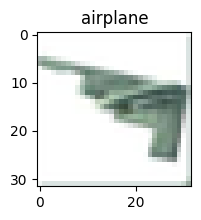

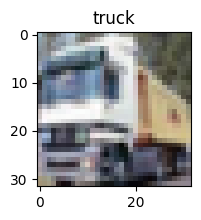

In [ ]:
def plot_image(number, file, label, pred=None):
    fig = plt.figure(figsize = (3,2))
    #img = return_photo(batch_file)
    plt.imshow(file[number])
    if pred is None:
        plt.title(classes[label[number]])
    else:
        plt.title('Label_true: ' + classes[label[number]] + '\nLabel_pred: ' + classes[pred[number]])

plot_image(12345, X_train, Y_train)
plot_image(1, X_train, Y_train)

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

import torchvision.transforms as transforms
def normalize_dataset(data):
    mean = data.mean(axis=(0,1,2)) / 255.0
    std = data.std(axis=(0,1,2)) / 255.0
    normalize = transforms.Normalize(mean=mean, std=std)
    return normalize

def get_transform():
    transform = transforms.Compose([
        transforms.RandAugment(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    return transform

def simple_transform():
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    return transform

In [ ]:
import torch
import torchvision.transforms as transforms
import random
from torch.utils.data import Dataset
from PIL import Image

# define the random seed for reproducible result
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


class CIFAR10_from_array(Dataset):
    def __init__(self, data, label, transform=None):

        self.data = data
        self.label = label
        self.transform = transform
        self.img_shape = data.shape

    def __getitem__(self, index):

        img = Image.fromarray(self.data[index])
        label = self.label[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img_to_tensor = transforms.ToTensor()
            img = img_to_tensor(img)
            #label = torch.from_numpy(label).long()
        return img, label

    def __len__(self):
        return len(self.data)

    def plot_image(self, number):
        file = self.data
        label = self.label
        fig = plt.figure(figsize = (3,2))
        #img = return_photo(batch_file)
        plt.imshow(file[number])
        plt.title(classes[label[number]])

In [ ]:
from sklearn.model_selection import train_test_split
X_unlabelled, X_labelled, y_unlabelled, y_labelled = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [ ]:
def normalize_dataset(data):
    mean = data.mean(axis=(0,1,2)) / 255.0
    std = data.std(axis=(0,1,2)) / 255.0
    normalize = transforms.Normalize(mean=mean, std=std)
    return normalize

train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_dataset(X_unlabelled)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_labelled)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_test)
])

unlabelled_trainset = CIFAR10_from_array(data=X_unlabelled, label=y_unlabelled, transform=train_transform_aug)
unlabelled_trainset_aug = CIFAR10_from_array(data=X_unlabelled, label=y_unlabelled, transform=val_transform)
labelled_trainset = CIFAR10_from_array(data=X_labelled, label=y_labelled, transform=val_transform)
testset = CIFAR10_from_array(data=X_test, label=Y_test, transform=test_transform)

In [ ]:
print('training set:'.ljust(20) + '{}'.format(unlabelled_trainset.img_shape))
print('validation set:'.ljust(20) + '{}'.format(labelled_trainset.img_shape))
print('testing set:'.ljust(20) + '{}'.format(testset.img_shape))
print('label numbers:'.ljust(20) + '{}'.format(len(set(labelled_trainset.label))))

training set:       (40000, 32, 32, 3)
validation set:     (10000, 32, 32, 3)
testing set:        (10000, 32, 32, 3)
label numbers:      10


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 1

unlabelled_train_loader = DataLoader(dataset=unlabelled_trainset,batch_size=batch_size, shuffle=True,num_workers=num_workers)
unlabelled_train_loader_aug = DataLoader(dataset=unlabelled_trainset_aug,batch_size=batch_size, shuffle=True,num_workers=num_workers)
labelled_train_loader = DataLoader(dataset=labelled_trainset,batch_size=batch_size, shuffle=False,num_workers=num_workers)
test_loader = DataLoader(dataset=testset,batch_size=batch_size, shuffle=False,num_workers=num_workers)

In [ ]:
unlabelled_iterable = iter(unlabelled_train_loader)
unlabelled_iterable_aug = iter(unlabelled_train_loader_aug)
labelled_iterable = iter(labelled_train_loader)
test_iterable = iter(test_loader)
# imgs, lbls = next(unlabelled_iterable)
# print ('Size of image:', imgs.size())
# print ('Type of image:', imgs.dtype)
# print ('Size of label:', lbls.size())
# print ('Type of label:', lbls.dtype)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import numpy as np

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

if __name__ == '__main__':
    net=Wide_ResNet(28, 10, 0.3, 10)
    y = net(Variable(torch.randn(1,3,32,32)))

    print(y.size())


| Wide-Resnet 28x10
torch.Size([1, 10])


In [ ]:
model = Wide_ResNet(28,2,0.3,10).to(device)

| Wide-Resnet 28x2


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true.to(device), y_pred.to(device)).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
beta_0 = 8

In [ ]:
import torch.optim as optim
acc=0

EPOCHS = 100
for epoch in range(EPOCHS):
  model.train()
  for epoch in range(len(unlabelled_train_loader)):
    labeled_images, labels = next(labelled_iterable)
    unlabeled_images,donttake = next(unlabelled_iterable)
    unlabeled_images_aug,donttake_aug = next(unlabelled_iterable_aug)

    pseudo_labels = torch.argmax(torch.softmax(model(unlabeled_images.to(device)), dim=1), dim=1).to(device)

    optimizer.zero_grad()

    unlabeled_logits_aug = model(unlabeled_images_aug.to(device)).to(device)
    unlabeled_logits = model(unlabeled_images.to(device)).to(device)
    labeled_logits = model(labeled_images.to(device)).to(device)

    loss_1 = nn.CrossEntropyLoss()(unlabeled_logits_aug, pseudo_labels)
    loss_labelled_1 = nn.CrossEntropyLoss()(labeled_logits.to(device), labels.to(device)).to(device)

    (loss_1).backward()
    optimizer.step()

    new_labeled_logits = model(labeled_images.to(device)).to(device)
    loss_labelled_2 = nn.CrossEntropyLoss()(new_labeled_logits, labels.to(device)).to(device)

    new_unlabeled_logits = model(unlabeled_images.to(device)).to(device)
    new_unlabeled_logits_aug = model(unlabeled_images_aug.to(device)).to(device)

    with torch.no_grad():
        pseudo_labels_unlabeled = torch.softmax(model(unlabeled_images.to(device)).to(device), dim=1)

    beta_k = beta_0 * torch.min(torch.tensor(1,dtype=torch.float32), ((epoch + torch.tensor(1,dtype=torch.float32)) /torch.tensor(8,dtype=torch.float32)))

    mask, dontcare = torch.max(torch.softmax(new_unlabeled_logits_aug, dim=1), dim=1)

    loss_partial = beta_k * torch.mean(torch.sum(-(torch.softmax(new_unlabeled_logits, dim=1)) * torch.log(torch.softmax(new_unlabeled_logits_aug, dim=1)), dim=-1) * mask)

    loss_uda = loss_labelled_2 + loss_partial

    with torch.no_grad():
        new_pseudo_labels = torch.argmax(torch.softmax(new_unlabeled_logits, dim=1), dim=1).to(device)

    new_loss = loss_labelled_2.item()
    old_loss = loss_labelled_1.item()
    change = new_loss - old_loss
    loss_mpl = ((change) * (nn.CrossEntropyLoss()(new_unlabeled_logits, new_pseudo_labels)))

    loss_2 = loss_uda + loss_mpl
    (loss_2).backward()
    optimizer.step()


  model.eval()

  for batch in range(len(test_loader)):
      test_images, test_labels = next(test_iterable)

      test_logits = model(test_images.to(device))
      pred_labels = torch.argmax(torch.softmax(test_logits, dim=1).to(device), dim=1).to(device)
      acc += accuracy_fn(test_labels, pred_labels)

  print("Accuracy per epoch :", acc / len(test_loader))




In [ ]:
def evaluate_model(model, test_loader, criterion, device):
  acc=0
  torch.manual_seed(43)
  test_batches = iter(test_loader)
  torch.manual_seed(43)
  labeled_batches = iter(labelled_trainset)
  model.eval()
  for _ in range(len(test_loader)):
    try:
        test_images, test_labels = next(test_batches)
    except StopIteration:
        test_batches = iter(test_loader)
        test_images, test_labels = next(test_batches)

    test_logits = model(test_images.to(device))
    pred_labels = torch.argmax(torch.softmax(test_logits,dim=1).to(device),dim=1).to(device)
    acc += accuracy_fn(test_labels, pred_labels)

  print("Accuracy per epoch :", acc/len(test_loader))

In [ ]:
evaluate_model(model, test_loader, criterion, device)